In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, mean_squared_error, r2_score



✅ Dataset Loaded: (1800, 13)
  Booking_ID        User_Type      Location_Zone         Slot_Type Start_Time  \
0      B1000          Regular  Airport_Proximity  Commercial_Space      12:15   
1      B1001          Regular        Residential          Driveway      17:15   
2      B1002          Regular         Commercial     Apartment_Lot      20:15   
3      B1003  Office_Commuter  Airport_Proximity  Commercial_Space      14:15   
4      B1004          Regular             IT_Hub          Driveway      13:45   

   Duration_Hours  Base_Price_Per_Hour  Dynamic_Price_Per_Hour  \
0               2                85.79                   85.79   
1               3                47.67                   47.67   
2               2                95.59                   95.59   
3               1                73.94                   96.12   
4               2                67.78                   67.78   

  Occupancy_Status Payment_Mode  User_Rating   Event_Tag Anomaly  
0        Available 

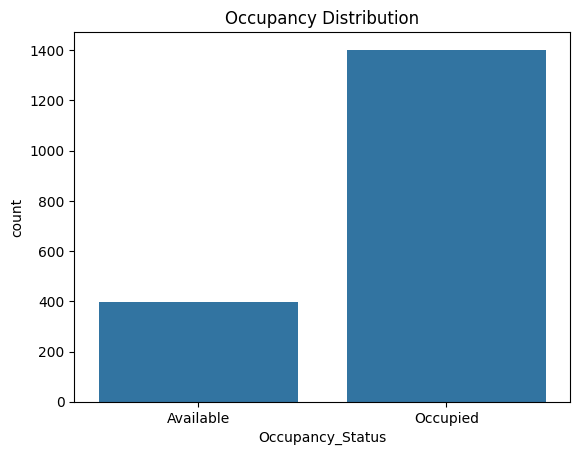

In [2]:
# Exploratory Data Analysis

df = pd.read_csv('smartpark_india_synthetic_dataset.csv')
print("\n✅ Dataset Loaded:", df.shape)
print(df.head())
print(df.info())
print(df.describe())
sns.countplot(x='Occupancy_Status', data=df)
plt.title('Occupancy Distribution')
plt.show()

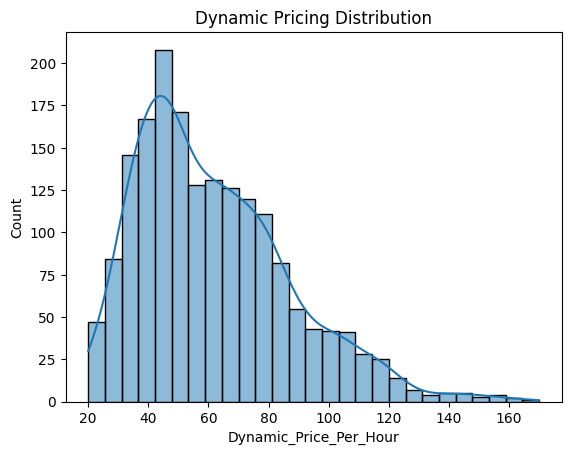

In [3]:
sns.histplot(df['Dynamic_Price_Per_Hour'], kde=True)
plt.title('Dynamic Pricing Distribution')
plt.show()

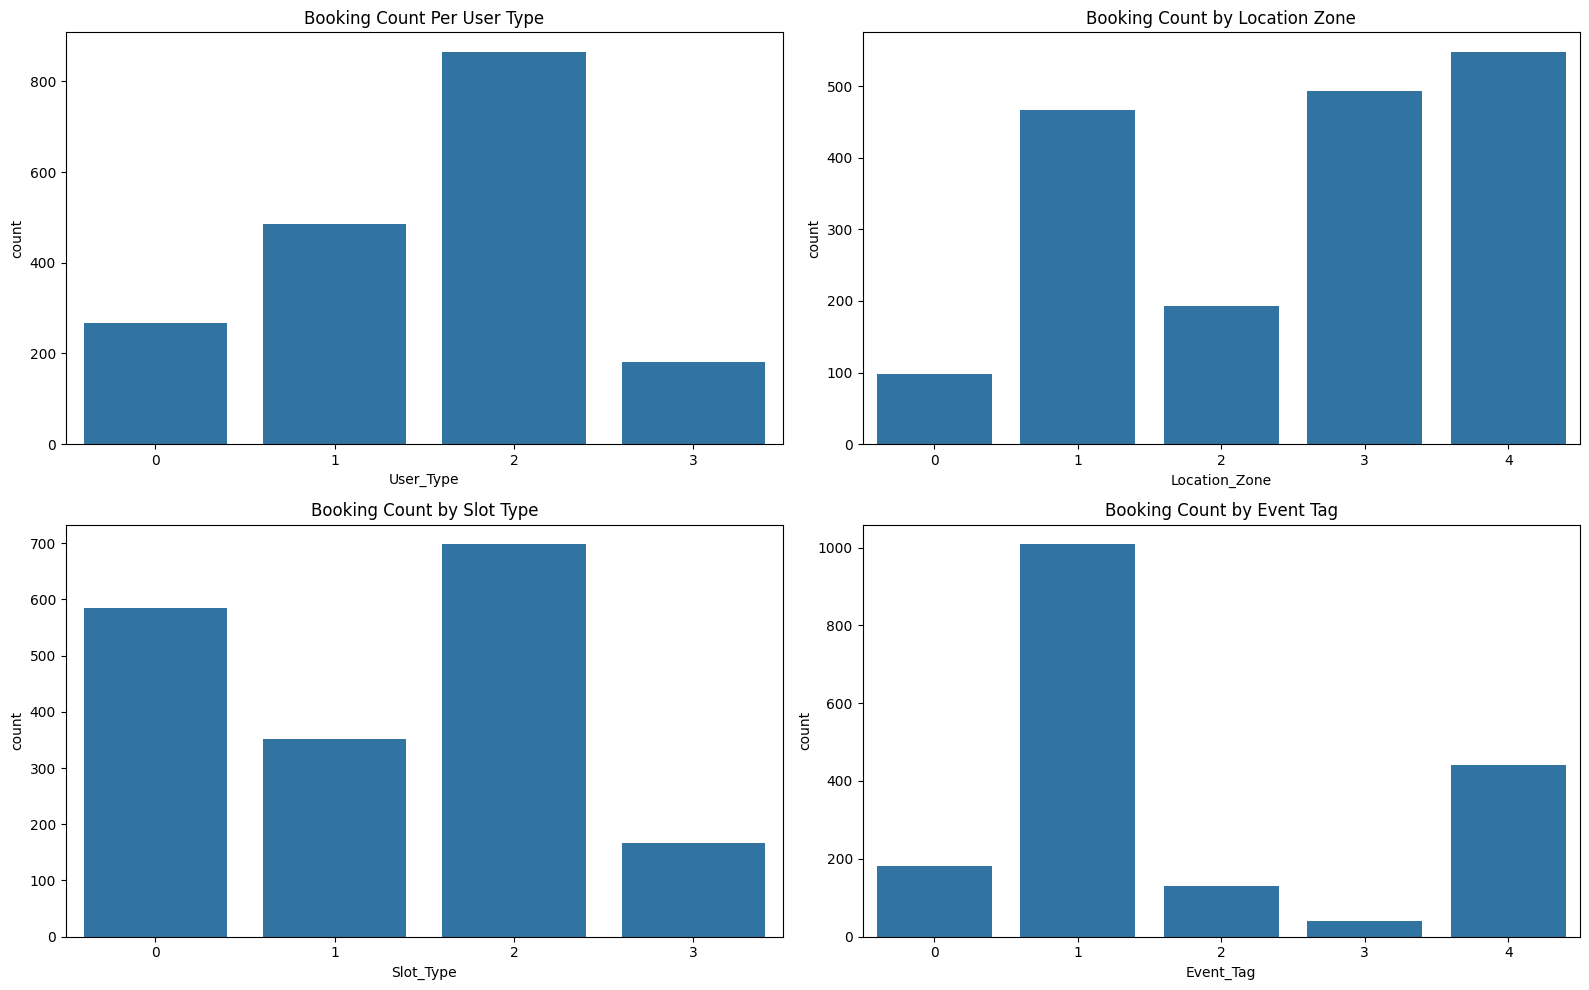

In [13]:
# Countplots - Categorical Features
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
sns.countplot(x='User_Type', data = df)
plt.title("Booking Count Per User Type")

plt.subplot(2, 2, 2)
sns.countplot(x='Location_Zone', data=df)
plt.title('Booking Count by Location Zone')

plt.subplot(2, 2, 3)
sns.countplot(x='Slot_Type', data=df)
plt.title('Booking Count by Slot Type')


plt.subplot(2, 2, 4)
sns.countplot(x='Event_Tag', data=df)
plt.title('Booking Count by Event Tag')

plt.tight_layout()
plt.show()

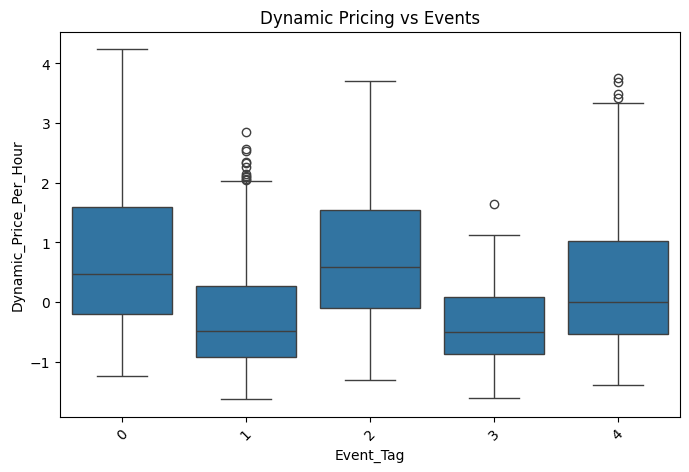

In [16]:

plt.figure(figsize=(8,5))
sns.boxplot(x='Event_Tag', y='Dynamic_Price_Per_Hour', data=df)
plt.title('Dynamic Pricing vs Events')
plt.xticks(rotation=45)
plt.show()

In [4]:
#pre processing
# Extract hour from Start_Time
df['Start_Hour'] = df['Start_Time'].str.split(':').str[0].astype(int)
df.drop(['Booking_ID', 'Start_Time'], axis=1, inplace=True)

# Fill missing ratings
df['User_Rating'].fillna(df['User_Rating'].median(), inplace=True)


C:\Users\srekilli\AppData\Local\Temp\ipykernel_25952\3412265563.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['User_Rating'].fillna(df['User_Rating'].median(), inplace=True)


In [5]:
#Label Encoding
categorical_cols = ['User_Type', 'Location_Zone', 'Slot_Type', 'Payment_Mode', 'Event_Tag', 'Anomaly']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
le_occ = LabelEncoder()
df['Occupancy_Status'] = le_occ.fit_transform(df['Occupancy_Status'])



In [17]:
# scaling Numerical Columns

num_cols = ['Duration_Hours', 'Base_Price_Per_Hour', 'Dynamic_Price_Per_Hour', 'User_Rating', 'Start_Hour']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("\n✅ Preprocessing Done\n")


✅ Preprocessing Done



In [ ]:
#Demand Prediction

X = df.drop(['Occupancy_Status'], axis=1)
y = df['Occupancy_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\n Demand Prediction Classification Report\n")
print(classification_report(y_test, y_pred))


✅ Demand Prediction Classification Report

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        96
           1       1.00      0.95      0.97       264

    accuracy                           0.96       360
   macro avg       0.94      0.98      0.96       360
weighted avg       0.97      0.96      0.96       360



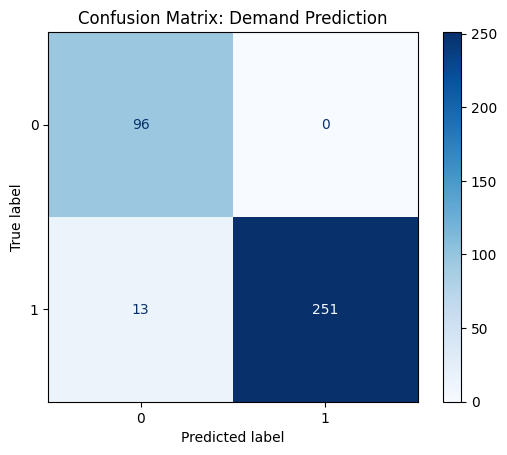

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix: Demand Prediction')
plt.show()

In [9]:
#  Step 4: Dynamic Pricing Model
import numpy as np
X_price = df.drop(['Dynamic_Price_Per_Hour'], axis=1)
y_price = df['Dynamic_Price_Per_Hour']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_price, y_price, test_size=0.2, random_state=42)
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_p, y_train_p)
y_pred_p = reg.predict(X_test_p)

mse = mean_squared_error(y_test_p, y_pred_p)
rmse = np.sqrt(mse)
print("\n Dynamic Pricing Regression Report\n")
print("RMSE:", rmse)
print("R2 Score:", r2_score(y_test_p, y_pred_p))


 Dynamic Pricing Regression Report

RMSE: 0.1310195455721201
R2 Score: 0.9838568891069633


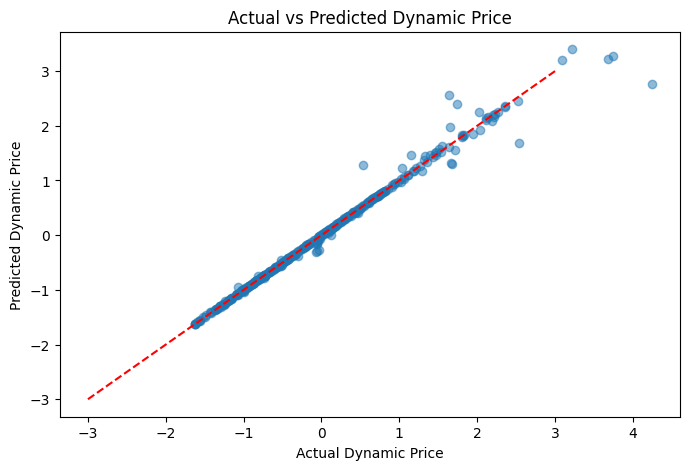

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(y_test_p, y_pred_p, alpha=0.5)
plt.xlabel("Actual Dynamic Price")
plt.ylabel("Predicted Dynamic Price")
plt.title("Actual vs Predicted Dynamic Price")
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--')
plt.show()


In [10]:
# Anamoly Detection

X_anomaly = df.drop(['Anomaly', 'Occupancy_Status'], axis=1)
iso = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Pred'] = iso.fit_predict(X_anomaly)
print("\n Anomaly Detection Completed\n")
print(df['Anomaly_Pred'].value_counts())



 Anomaly Detection Completed

Anomaly_Pred
 1    1710
-1      90
Name: count, dtype: int64


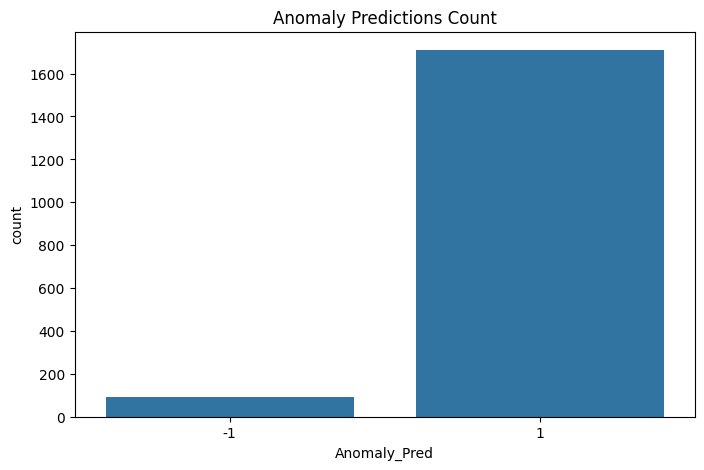

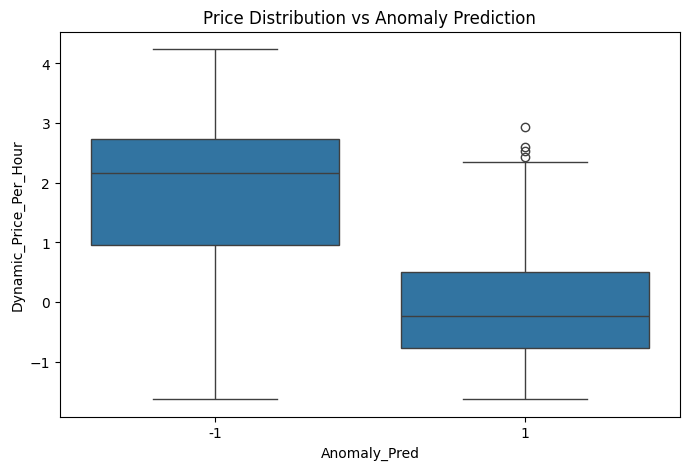

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x='Anomaly_Pred', data=df)
plt.title('Anomaly Predictions Count')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Anomaly_Pred', y='Dynamic_Price_Per_Hour', data=df)
plt.title('Price Distribution vs Anomaly Prediction')
plt.show()


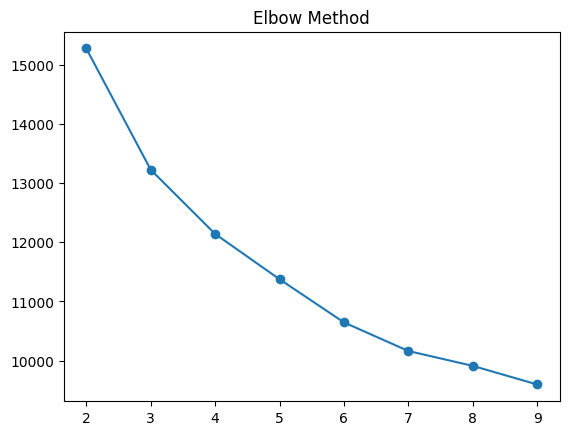

In [11]:
# clustering

X_cluster = df.drop(['Anomaly', 'Occupancy_Status', 'Anomaly_Pred'], axis=1)
X_cluster = X_cluster.dropna().reset_index(drop=True)

inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.show()



✅ Clustering Completed

Cluster_Label
3    828
1    477
0    302
2    193
Name: count, dtype: int64


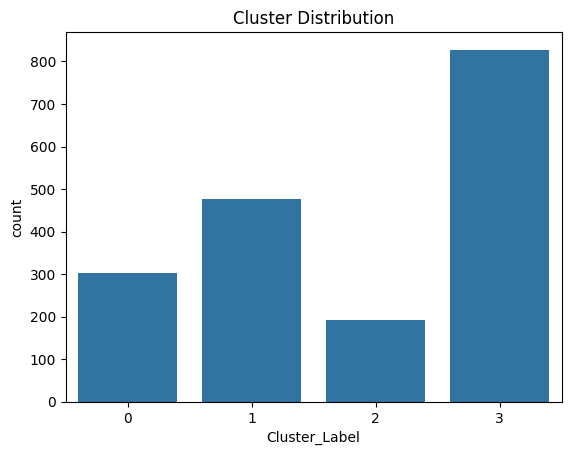

In [12]:
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_cluster)
df['Cluster_Label'] = kmeans_final.labels_
print("\n✅ Clustering Completed\n")
print(df['Cluster_Label'].value_counts())
sns.countplot(x='Cluster_Label', data=df)
plt.title('Cluster Distribution')
plt.show()
